# Weibull Distribution
## Calculate parameters from data using linear regression

### ワイブル分布関数とその関係式
> $R(t) = \exp\left [-\left ( \frac{t-\gamma}{\beta} \right )^m \right ]\cdots信頼度$ <br>
$F(t)=1-\exp\left [-\left ( \frac{t-\gamma}{\beta} \right )^m \right ]\cdots不信頼度$ <br>
$f(t)=\frac{t^{m-1}}{\beta^m}\exp\left [-\left ( \frac{t}{\beta} \right )^m \right ]\cdots故障確率の密度関数$   $(\gamma=0)$<br>
$\lambda(t)=\frac{m}{\beta}\left ( \frac{t}{\beta} \right )^{m-1}\cdots故障率$<br>
$\tau = \beta  \Gamma\left(1+\frac{1}{m} \right )\cdots平均寿命$<br>
$\sigma^2 = \beta^2 \left [ \Gamma \left ( 1+\frac{2}{m} \right ) - \left \{ \Gamma \left( 1+\frac{1}{m}\right ) \right \}^2 \right ]\cdots分散$<br>
$\sigma=\sqrt{\sigma^2}=\beta \sqrt{  \Gamma \left ( 1+\frac{2}{m} \right ) - \left \{ \Gamma \left( 1+\frac{1}{m}\right ) \right \}^2 }\cdots標準偏差$

### 文字の説明
$\gamma\cdots時間位置パラメーター(初期、偶発、摩耗故障期のグラフを描くとき、時間が連続的になるように、時間方向に平行移動)$<br>
$m\cdots$形状パラメーター(初期$(m<1)$or偶発$(m=1)$or摩耗故障期$(m>1)$)<br>
$\beta\cdots尺度パラメータ$(時間と故障の速度の関係を表す係数)<br><br>
$n\cdots製品総数$<br>
$i\cdots i番目に故障$

各製品の故障時刻のリストから、不信頼度$F(t)$を推定 
- 平均ランク法
> $F(t_i) \approx \frac {i}{n+1}$ <br>

- メディアンランク法
> $F(t_i) \approx \frac {i-0.3}{n+0.4}$<br>

- モードランク法
> $F(t_i) \approx \frac {i-1}{n-1}$


## 各製品の故障時刻のリストからワイブル分布のパラメーターを決定
1. 各製品の故障時刻のリストを用意
2. 製品総数と故障した順番から$F(t_i)$を推定(平均ランク法やメディアンランク法、モードランク法などによる推定がある。)
3. 横軸に$X=ln(t)$、縦軸に$Y=\ln\ln\left ( \frac{1}{1-F(t_i)} \right )$をとったグラフにプロット
4. 3のプロットを最小二乗法で1次近似Fitする。
5. 4で得られた傾きと切片より、$m=slope, \beta=\exp \left [ - \frac{intercept}{slope} \right ]$というようにワイブル分布のパラメータを決定する。
6. ワイブル関数の式が求まる。上記の公式から平均寿命や標準偏差を求める。

In [1]:
import numpy as np
from math import gamma, e, sqrt
from sklearn.linear_model import LinearRegression

### 1. 故障時刻のリストを用意

In [2]:
# 1. 各製品の故障リストを用意 (故障時刻が小さい順になるように並べる)
failure_time_list = np.sort(np.array([3.3, 6.8, 0.8, 1.3, 5.1, 2.9, 2.5, 3.8, 4.4, 2.0]))
failure_time_list

array([0.8, 1.3, 2. , 2.5, 2.9, 3.3, 3.8, 4.4, 5.1, 6.8])

### 2. $F(t_i)$の推定
### 3. ワイブル確率紙へプロット

In [3]:
# F(t_i) の推定 関数を作る
# 平均ランク法　近似
def predict_F_mean_rank(failure_time_list):
    n = failure_time_list.size
    i = np.arange(1, n+1) # 50x faster than np.array([x for x in range(1, n+1)])
    return i / (n+1)

# メディアンランク法　近似
def predict_F_median_rank(failure_time_list):
    n = failure_time_list.size
    i = np.arange(1, n+1)
    return (i-0.3) / (n+0.4)

# モードランク法　近似
def predict_F_median_rank(failure_time_list):
    n = failure_time_list.size
    i = np.arange(1, n+1) 
    return (i-1) / (n-1)

In [4]:
# 2. Fを推定 (今回は平均ランク法を使用)
Ft = predict_F_mean_rank(failure_time_list)

# 3. lnln(1/(1-Ft)) を求める (これでワイブル確率紙上にプロットするための座標が得られる。)
lnln = np.log(np.log(1. / (1. - Ft)))

### 4. 最小二乗法でワイブル確率紙上での傾きと切片を求める

In [5]:
# 4. Linear Regressionにより直線近似
# scikit-learnを使うためにfeature_matrix, target_arrayをつくる
feature_matrix = np.log(failure_time_list).reshape(failure_time_list.size, 1)
target_array = lnln

print(feature_matrix)
print(target_array.round(2))

[[-0.22314355]
 [ 0.26236426]
 [ 0.69314718]
 [ 0.91629073]
 [ 1.06471074]
 [ 1.19392247]
 [ 1.33500107]
 [ 1.48160454]
 [ 1.62924054]
 [ 1.91692261]]
[-2.35 -1.61 -1.14 -0.79 -0.5  -0.24  0.01  0.26  0.53  0.87]


In [6]:
# scikit-learn reg modelで直線近似
reg = LinearRegression().fit(feature_matrix, target_array)
print("fit accuracy = {:.2g}".format(reg.score(feature_matrix, target_array))) # print accuracy 0.0-1.0

# 傾きと切片が得られる。
slope = reg.coef_[-1] # In this time, coef_ means slope
intercept = reg.intercept_

print("\nワイブル確率紙上にて")
print("slope        = {:6.4g}".format(slope))
print("intercept    = {:6.4g}".format(intercept))

fit accuracy = 0.99

ワイブル確率紙上にて
slope        =  1.544
intercept    = -2.081


### 5. ワイブル分布関数のパラメータ$m$と$\beta$を求める。

In [7]:
# 5. ワイブル分布関数のパラメーターを4.で求めた傾きと切片から求める。
m = slope
β = e ** (- intercept / slope)

### 6. 平均寿命$\tau$、標準偏差$\sigma$を求める

In [8]:
# 6. ワイブル分布関数が求まった。
# 7. 平均寿命　標準偏差を求める。
τ = β * gamma(1 + 1/m)
σ = β * sqrt(gamma(1 + 2/m) - gamma(1 + 1/m))# **2)

### 結果

In [9]:
# 各種求まった値をプリント
print("ワイブル分布関数のパラメーター")
print("m = {:.4g}".format(m))
print("β = {:.4g}".format(β))
print()
print("平均寿命τ = {:.3g}".format(τ))
print("標準偏差σ = {:.3g}".format(σ))
print("単位を忘れるな!!")

ワイブル分布関数のパラメーター
m = 1.544
β = 3.849

平均寿命τ = 3.46
標準偏差σ = 1.98
単位を忘れるな!!


## Visualize the prediction

In [10]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')


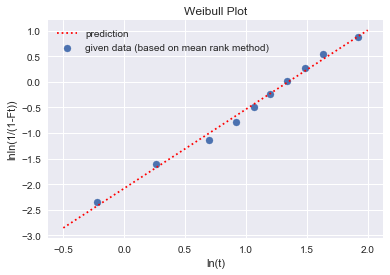

In [11]:
plt.scatter(np.log(failure_time_list), lnln, label='given data (based on mean rank method)')
plt.plot(np.linspace(-0.5, 2, 10), slope*np.linspace(-0.5, 2, 10)+intercept, ls=':', color='red', label='prediction')
plt.legend()
plt.xlabel('ln(t)')
plt.ylabel('lnln(1/(1-Ft))')
plt.title('Weibull Plot');